# SIMEX notebook for wavefront propagation using the SimEx Calculator "WavePropagator".

In this notebook, we will demonstrate how to propagate a simple Gaussian wavefront between two planes through vacuum. This is the simplest case of coherent wavefront propagation.

In [1]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

initializing ocelot...


In [2]:
import SimEx
SimEx.__file__

'/gpfs/exfel/data/user/grotec/Codes/eucall-software/simex_platform/develop/Sources/python/SimEx/__init__.py'

### Setup the initial wavefront
We first create a wavefront with a Gaussian intensity distribution. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`. Looking up the documentation of these two classes gives us the information needed to create the instances:

In [5]:
GaussWavefrontParameters?

In [6]:
GaussianPhotonSource?

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [3]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-5,
                                                beam_diameter_fwhm=1.0e-3*meter,
                                                pulse_energy=2.0e-6*joule,
                                                divergence=3e-6*radian,
                                                number_of_transverse_grid_points=128,
                                                number_of_time_slices=8,
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [4]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [5]:
photon_source.backengine()

We can retrieve the wavefront data from the calculator:

In [6]:
wavefront = photon_source.data

In [7]:
wavefront.params.Rx = 1.0

In [8]:
wavefront.params.Ry = 1.0

Let's visualize the wavefront using the WPG utilities.

In [9]:
from wpg import wpg_uti_wf as wpg_utils

First plot the intensity distribution

R-space
(128,) (128,)
FWHM in x = 2.775e-05 m.
FWHM in y = 2.775e-05 m.


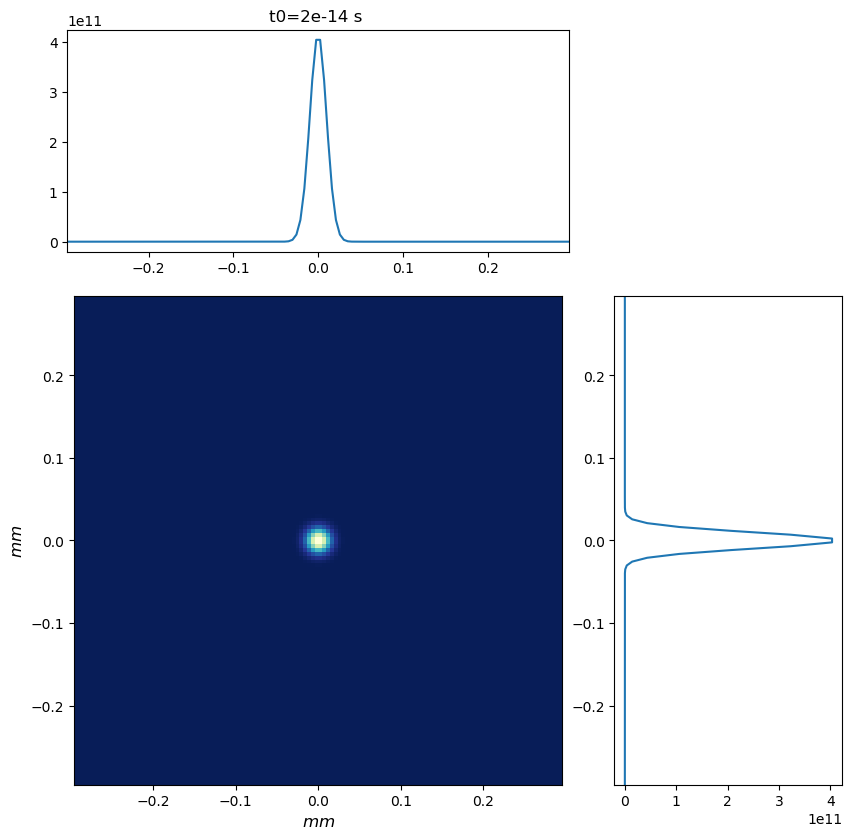

In [10]:
wpg_utils.plot_intensity_map(wavefront)

Plot the power as a function of time integrated over the transverse dimensions

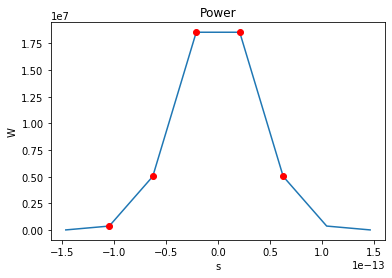

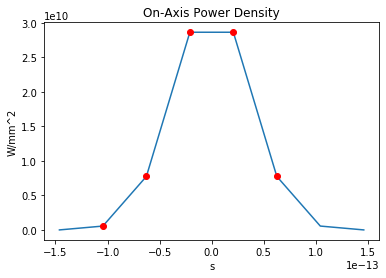

number of meaningful slices: 5
Pulse energy 2e-06 J


9498110.4

In [11]:

wpg_utils.integral_intensity(wavefront)

Plot the power spectrum

In [12]:
import wpg

In [ ]:
wpg.srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')

Check the sampling quality

In [16]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|2.368e-05|1.484e-06|5.920e-04|1.000e+00|3.270e-06|1.039e-05|1.484e-05|
|Vertical  |2.368e-05|1.484e-06|5.920e-04|1.000e+00|3.270e-06|1.039e-05|1.484e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


Ok, we're happy with our initial wavefront and will now proceed to setup the beamline. Our beamline will consist just of a stretch of vacuum over 10 m distance.

In [20]:
from wpg import Beamline, optical_elements, 

In [17]:
beamline = wpg.Beamline()

In [21]:
optical_elements.Drift?

In [22]:
free_space = wpg.optical_elements.Drift(_L=10, _treat=1)

In [24]:
free_space_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=1)

In [25]:
beamline.append(free_space, free_space_propagation_parameters)

In [ ]:
beamline.propagate(wavefront)

In [87]:
propagation_parameters = WavePropagatorParameters(beamline=exfel_spb_kb_beamline)

In [72]:
propagator = XFELPhotonPropagator(parameters=propagation_parameters,
                                  input_path='FELsource_out_0000001.h5',
                                  output_path='prop_out.h5')

In [11]:
propagator.backengine()

0

In [73]:
propagator.saveH5()

Analyse propagated wavefronts

In [88]:
prop_analysis=XFELPhotonAnalysis(input_path='prop_out.h5')


 Start initialization.

 Loading wavefront from prop_out.h5.
 ... done.

 Getting intensities.
 ... done.
 Data dimensions =  (42, 84, 651)

 Masking NANs.
 ... done.


## Plot FEL spectrum before propagation


 Plotting total power.

 Switching to frequency domain.


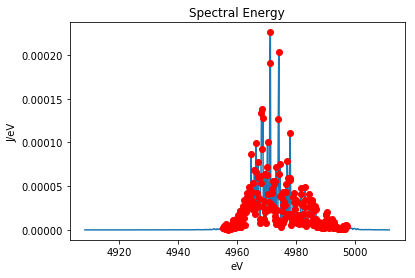

In [75]:
# Plot FEL spectrum at source and after propagation
source_analysis.plotTotalPower(spectrum=True)

## Plot FEL spectrum after propagation


 Plotting total power.

 Switching to frequency domain.


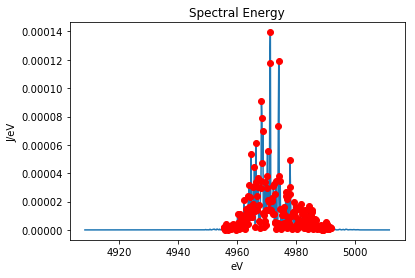

In [76]:
prop_analysis.plotTotalPower(spectrum=True)


 Plotting intensity map.
R-space


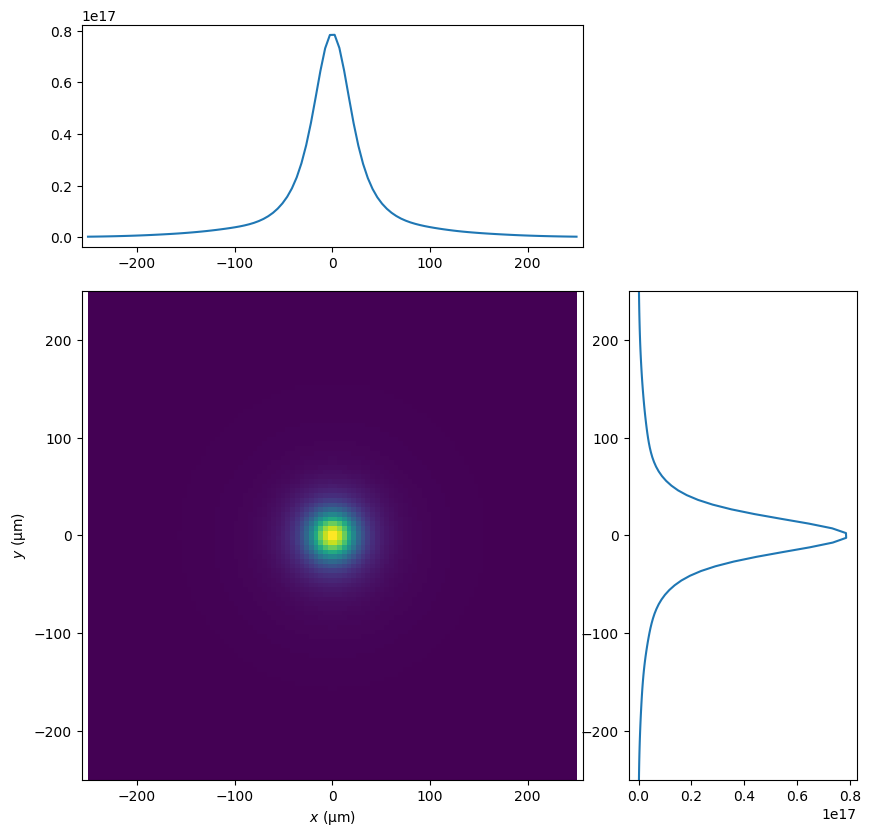

In [22]:
# Plot source and sample intensity map
source_analysis.plotIntensityMap()


 Plotting intensity map.
R-space


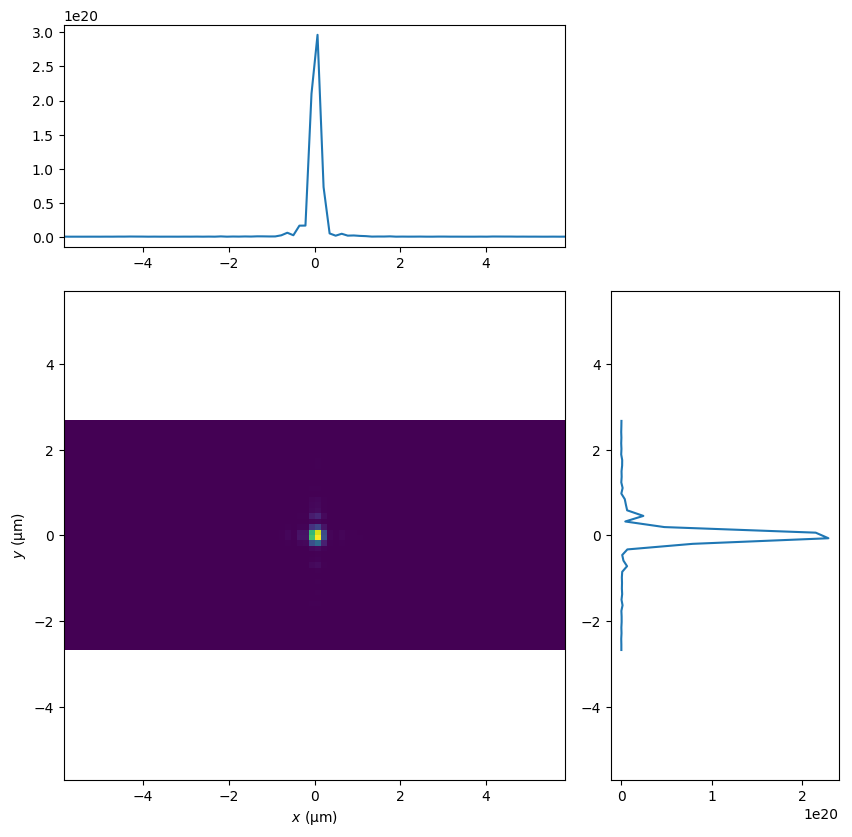

In [23]:
prop_analysis.plotIntensityMap()

## Step 3: Photon-Matter interaction

In [89]:
pmi_parameters={"number_of_trajectories" : 1,
                "random_rotation" : False}

photon_matter_interactor=XMDYNPhotonMatterInteractor(parameters=pmi_parameters,
                                                         input_path='prop_out.h5',
                                                         output_path='pmi_out',
                                                         sample_path='2nip.pdb')

Sample file 2nip.pdb was not found. Will attempt to query from RCSB protein data bank.


In [ ]:
photon_matter_interactor.backengine()
photon_matter_interactor.saveH5()

## Step 4: Scattering 

### Configure Detector geometry

#### One panel

In [28]:
panel = DetectorPanel(ranges={"fast_scan_min" : 0, "fast_scan_max" : 100,
                              "slow_scan_min" : 0, "slow_scan_max" : 100},
                      pixel_size=6*220.0e-6*meter,
                      energy_response=1.0/electronvolt,
                      distance_from_interaction_plane=0.13*meter,
                      corners={"x" : -49, "y": -49},
                      saturation_adu=1.e6,
                      )

In [29]:
detector_geometry = DetectorGeometry(panels=panel,)

### Configure the Diffractor Parameters

In [36]:
diffraction_parameters = SingFELPhotonDiffractorParameters(
                                               uniform_rotation=False,
                                               slice_interval=100,
                                               number_of_slices=100,
                                               number_of_diffraction_patterns=50,
                                               detector_geometry=detector_geometry,
                                               forced_mpi_command='mpirun -np 50',
                                              )

### Initialize the Diffractor 

In [37]:
diffractor = SingFELPhotonDiffractor(parameters=diffraction_parameters,
                                     input_path='pmi/',
                                     output_path="diffr")

### Run the scattering simulation

In [38]:
diffractor.backengine()
diffractor.saveH5()

## Analysis 

### Setup analysis object 

In [90]:
spi_analysis = DiffractionAnalysis(diffractor.output_path,
                                   pattern_indices=range(1,50),
                                   poissonize=True,
                                   )

In [59]:
spi_analysislysis.animatePatterns("diffr_animated.gif")

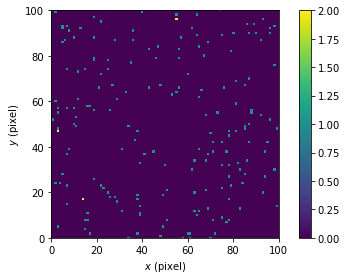

In [92]:
spi_analysis.plotPattern(operation=numpy.sum,logscale=False)

In [94]:
import wpg

In [95]:
wf = wpg.Wavefront()

In [96]:
wf.load_hdf5('prop_out.h5')

In [99]:
wf_intensity = wf.get_intensity()

In [139]:
wf_intensity.shape

(42, 84, 651)

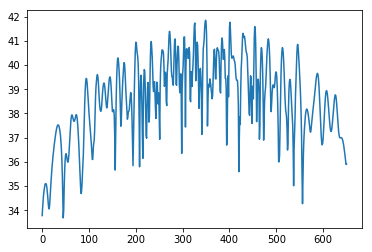

In [151]:
plot([numpy.log(wf_intensity[:,:,i].max()) for i in range(651)])

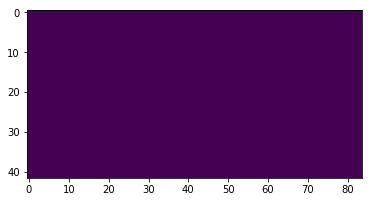

In [155]:
for i in range(wf_intensity.shape[-1]):
    if wf_intensity[:,:,i].max() < 1e14:
        continue
    imshow(wf_intensity[:,:,i], norm=Norm(vmin=1e15, vmax=1.5e18) )
    savefig("include/wf_intensity/wf_intensity_{0:03d}.png".format(i))
    #imsave("include/wf_intensity/wf_intensity_{0:03d}.png".format(i), wf_intensity[:,:,i], vmin=1e15, vmax=1.5e18 )

In [154]:
from matplotlib.pyplot import imshow, colorbar, imsave, plot, savefig
from matplotlib.colors import Normalize as Norm

In [101]:
wf_intensity.shape

(42, 84, 651)

In [55]:
mask = numpy.ones((101,101))
mask[40:60,40:60]=0.0

In [91]:
spi_analysis.mask = mask

# Cleanup

In [1]:
import os, shutil

In [2]:
# Cleanup previous run
dirs_to_remove=['diffr, pmi']
files_to_remove=['diffr.h5','5udc.pdb']

In [3]:
for d in dirs_to_remove:
    if os.path.isdir(d):
        shutil.rmtree(d)
for f in files_to_remove:
    if os.path.isfile(f):
        os.remove(f)
    